In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

from realnvp import RealNVP
from datasets import make_circles_ssl, make_moons_ssl, make_github_cat, make_npz
from distributions import SSLGaussMixture

from itertools import chain

%load_ext autoreload
%autoreload 2

In [2]:
class Nets(nn.Module):
    def __init__(self, D, inner_dim, inner_layers):
        super().__init__()
        self.seq_part = nn.Sequential(nn.Linear(D, inner_dim),
                                 nn.ReLU(),
                                 *inner_seq(inner_layers, inner_dim),
                                 nn.Linear(inner_dim, D),
                                 nn.Tanh())
        self.scale = nn.Parameter(torch.ones(D))
        
    
    def forward(self, x):
        x = self.seq_part.forward(x)
        x = self.scale * x
        return x

def inner_seq(n, inner_dim):
    res = []
    for _ in range(n):
        res.append(nn.Linear(inner_dim, inner_dim))
        res.append(nn.ReLU())
    return res

def get_toy_nvp(D, coupling_layers_num=6, inner_dim=256, inner_layers=2, prior=None, device=None):

    # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
    nets = lambda: Nets(D, inner_dim, inner_layers)
    nett = lambda: nn.Sequential(nn.Linear(D, inner_dim),
                                 nn.ReLU(),
                                 *inner_seq(inner_layers, inner_dim),
                                 nn.Linear(inner_dim, D))
    
    if prior is None:
        prior = distributions.MultivariateNormal(torch.zeros(D).to(device),
                                                 torch.eye(D).to(device))
        
    d = D // 2
    masks = torch.zeros(coupling_layers_num, D)
    for i in range(masks.size(0)):
        if i % 2:
            masks[i, :d] = 1.
        else:
            masks[i, d:] = 1.
    masks.to(device)
    return RealNVP(nets, nett, masks, prior, device=device)

In [3]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy

In [42]:
from scipy.spatial.distance import cdist

def get_decision_boundary(xx, yy, flow):
    points = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    classes = flow.classify(torch.from_numpy(points).float())
    return classes

In [69]:
class FlowMixture(nn.Module):
    def __init__(self, n_components, flow_fun, *args, **kwargs):
        self.flows = [flow_fun(*args, **kwargs) for _ in range(n_components)]
        self.n_components = n_components
    
    def parameters(self):
        return chain(*[flow.parameters() for flow in self.flows])
        
    def f(self, x):
        return [flow.f(x) for flow in self.flows]
    
    def g(self, z):
        return [flow.g(x) for flow in self.flows]
    
    def log_prob(self, x, y=None):
        all_log_probs = [flow.log_prob(x) for flow in self.flows]
        log_probs = sum(all_log_probs) / self.n_components
        if y is not None:
            for i in range(self.n_components):
                mask = (y == i)
                log_probs[mask] = all_log_probs[i][mask]
        return log_probs
    
    def all_log_prob(self, x, y=None):
        all_log_probs = [flow.log_prob(x) for flow in self.flows]
        return all_log_probs
    
    def classify(self, x):
        all_log_probs = torch.cat([flow.log_prob(x)[:, None] for flow in self.flows], dim=1)
        return torch.argmax(all_log_probs, dim=1)

## Moons

In [70]:
r = 3.5
means = torch.tensor([[-r, -r], [r, r]], requires_grad=True)
prior = None

data, labels = make_moons_ssl()
labels = labels.astype(int)

flow = FlowMixture(n_components=2, flow_fun=get_toy_nvp, D=2, prior=prior, device=None, inner_dim=256, 
                   coupling_layers_num=6, inner_layers=2)


In [73]:
lr_init = 1e-4
epochs = 2001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 2.438
iter 500: loss = 0.742
iter 1000: loss = 0.439
iter 1500: loss = 0.205
iter 2000: loss = 0.235


Text(0.5, 1.0, 'Classifier')

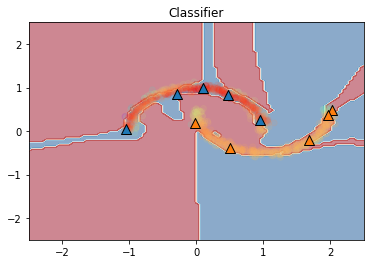

In [74]:
grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-2.5, 2.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

classes = get_decision_boundary(xx_x, yy_x, flow)
data_probs = flow.all_log_prob(torch.from_numpy(data).float())[0].detach().numpy()
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=data_probs, cmap=plt.cm.rainbow, alpha=0.1)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')

In [67]:
data_probs

array([-1.61451209e+00, -3.15949976e-01, -1.62069380e-01, -8.23522687e-01,
       -1.10778928e-01, -3.18719149e-01, -3.57899725e-01, -5.69036603e-02,
       -4.62096214e-01, -8.33084345e-01, -1.07768929e+00, -1.09649503e+00,
       -1.15091956e+00, -1.11299515e+00, -2.88886189e-01, -9.12140608e-01,
       -7.91005731e-01, -9.96112823e-04, -1.35944903e+00, -8.39989364e-01,
       -7.67780185e-01, -1.08971000e+00, -2.77865648e-01, -1.00973582e+00,
       -7.86850452e-01, -9.06778455e-01, -7.26545572e-01, -1.23326254e+00,
       -9.48194444e-01, -2.06308055e+00, -1.06314516e+00, -1.07588959e+00,
       -1.29888058e+00, -1.15797305e+00, -7.51940250e-01, -4.33718562e-01,
       -6.31199479e-01, -4.60870743e-01, -7.57091522e-01, -4.14872766e-01,
       -1.10012639e+00, -4.59676552e+00, -9.59824860e-01, -1.03930116e+00,
       -3.59135532e+00, -1.10497320e+00, -1.54385638e+00, -3.17620635e-02,
       -7.52430677e-01, -3.50442529e-01, -1.13038123e-01, -1.63764894e+00,
       -1.63108885e-01, -

## Circles

In [76]:
prior = None

data, labels = make_circles_ssl()
labels = labels.astype(int)

flow = FlowMixture(n_components=2, flow_fun=get_toy_nvp, D=2, prior=prior, device=None, inner_dim=256, 
                   coupling_layers_num=6, inner_layers=2)

In [80]:
lr_init = 1e-4
epochs = 5001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 2.193
iter 500: loss = 1.193
iter 1000: loss = 1.136
iter 1500: loss = 0.682
iter 2000: loss = 1.246
iter 2500: loss = 0.734
iter 3000: loss = 0.822
iter 3500: loss = 0.671
iter 4000: loss = 0.637
iter 4500: loss = 0.597
iter 5000: loss = 0.915


Text(0.5, 1.0, 'Classifier')

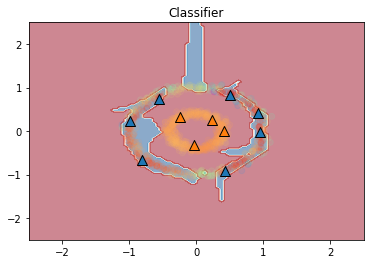

In [81]:
grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-2.5, 2.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

classes = get_decision_boundary(xx_x, yy_x, flow)
data_probs = flow.all_log_prob(torch.from_numpy(data).float())[0].detach().numpy()
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=data_probs, cmap=plt.cm.rainbow, alpha=0.1)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')

## 8 Gaussians

In [82]:
prior = None

data, labels = make_npz("8gauss.npz")
labels = labels.astype(int)

flow = FlowMixture(n_components=3, flow_fun=get_toy_nvp, D=2, prior=prior, device=None, inner_dim=256, 
                   coupling_layers_num=6, inner_layers=2)

In [84]:
lr_init = 1e-4
epochs = 5001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 6.261
iter 500: loss = 2.803
iter 1000: loss = 2.459
iter 1500: loss = 2.231
iter 2000: loss = 2.218
iter 2500: loss = 2.228
iter 3000: loss = 2.429
iter 3500: loss = 2.192
iter 4000: loss = 2.136
iter 4500: loss = 2.170
iter 5000: loss = 2.112


Text(0.5, 1.0, 'Classifier')

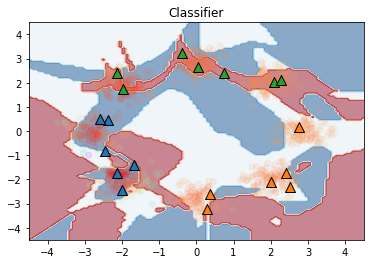

In [86]:
grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-4.5, 4.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

classes = get_decision_boundary(xx_x, yy_x, flow)
data_probs = flow.all_log_prob(torch.from_numpy(data).float())[0].detach().numpy()
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=data_probs, cmap=plt.cm.rainbow, alpha=0.1)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')

## Pinwheel

In [87]:
prior = None

data, labels = make_npz("pinwheel.npz")
# labels[labels == 1] = 10
# labels[labels == 0] = 1
# labels[labels == 10] = 0
labels = labels.astype(int)

flow = FlowMixture(n_components=5, flow_fun=get_toy_nvp, D=2, prior=prior, device=None, inner_dim=256, 
                   coupling_layers_num=6, inner_layers=2)

In [89]:
lr_init = 1e-4
epochs = 10001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 4.237
iter 500: loss = 2.063
iter 1000: loss = 1.911
iter 1500: loss = 1.285
iter 2000: loss = 1.253


KeyboardInterrupt: 

Text(0.5, 1.0, 'Classifier')

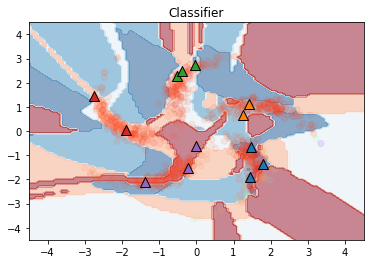

In [90]:
grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-4.5, 4.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

classes = get_decision_boundary(xx_x, yy_x, flow)
data_probs = flow.all_log_prob(torch.from_numpy(data).float())[0].detach().numpy()
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=data_probs, cmap=plt.cm.rainbow, alpha=0.1)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')